In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras.layers as kl
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import Regularizer

from tensorflow_probability import distributions as tfd

In [2]:
img_shape = [28, 28, 1]
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50

In [4]:
class GaussPriorRegularizer(Regularizer):
    def __init__(self, mu, sigma):
        self.mu = K.cast_to_floatx(mu)
        self.sigma = K.cast_to_floatx(sigma)
        
    def __call__(self, x):
        return - tfd.Normal(self.mu, self.sigma).log_prob(x)

In [10]:
class GaussComparator(kl.Layer):
    def __init__(self, expected_sigma):
        super().__init__()
        
        ls = np.log(expected_sigma)
        self.log_sigma = K.cast_to_floatx(ls)
#         self.log_sigma = self.add_weight(name="log_sigma", 
#                 initializer=keras.initializers.Constant(ls), 
#                 regularizer= GaussPriorRegularizer(ls, 2.0))
    @property
    def sigma(self):
        return tf.exp(self.log_sigma)
    
    def call(self, inputs):
        y_true, y_pred = inputs
        return - tfd.Normal(0, self.sigma).log_prob(y_true - y_pred)
        

In [11]:
comp = GaussComparator(expected_sigma=0.001)

In [12]:
comp([1., 1.])

<tf.Tensor: id=92, shape=(), dtype=float32, numpy=-5.9888167>

In [13]:
comp.losses

[]

In [14]:
decoder = keras.Sequential([
    kl.Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    kl.Dense(np.prod(img_shape), activation='sigmoid'),
    kl.Reshape(img_shape)
])

In [15]:
def build_encoder(img_shape):
    x = inp = kl.Input(shape=img_shape)
    x = kl.Flatten()(x)
    h = kl.Dense(intermediate_dim, activation='relu')(x)

    z_mu = kl.Dense(latent_dim)(h)
    z_log_var = kl.Dense(latent_dim)(h)
    return keras.Model(inp, [z_mu, z_log_var])

In [16]:
encoder = build_encoder(img_shape)

In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        x = inputs
        mu, log_var = self.encoder(x)
        kl_batch = - 1/2 *  K.sum(
            1 + log_var - mu**2 - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch))
        
        sigma = K.exp(log_var / 2)
        eps = tfd.Normal(0, 1).sample(tf.shape(mu))
        return self.decoder(mu + sigma * eps)
    
vae = VAE(encoder, decoder)

### Data

In [18]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train[..., None] / 255).astype(np.float32)
x_test = (x_test[..., None] / 255).astype(np.float32)

### Training

In [19]:
trainable_variables = vae.trainable_variables + comp.trainable_variables

In [20]:
def get_loss(x):
    l = nll(x, vae(x))
    l = l + tf.add_n(vae.losses)
    return l

In [24]:
def get_loss(x):
    l = comp([x, vae(x)])
    for submodel in [vae, comp]:
        if submodel.losses:
            l += tf.add_n(submodel.losses)
            
    return l

In [22]:
optimizer = tf.keras.optimizers.RMSprop()

loss_metric = tf.keras.metrics.Mean()

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(256)

In [34]:
# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    loss_metric.reset_states()
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss = get_loss(x_batch_train)

        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))

        loss_metric(loss)

    print('loss =', loss_metric.result().numpy(), "; sigma =", comp.sigma.numpy())

Start of epoch 0
loss = 18768.455 ; sigma = 0.0009999999
Start of epoch 1
loss = 18770.795 ; sigma = 0.0009999999
Start of epoch 2
loss = 18762.77 ; sigma = 0.0009999999
Start of epoch 3
loss = 18750.736 ; sigma = 0.0009999999
Start of epoch 4
loss = 18744.564 ; sigma = 0.0009999999
Start of epoch 5
loss = 18745.277 ; sigma = 0.0009999999
Start of epoch 6
loss = 18732.242 ; sigma = 0.0009999999
Start of epoch 7
loss = 18735.92 ; sigma = 0.0009999999
Start of epoch 8
loss = 18723.047 ; sigma = 0.0009999999
Start of epoch 9
loss = 18718.857 ; sigma = 0.0009999999
Start of epoch 10
loss = 18717.887 ; sigma = 0.0009999999
Start of epoch 11
loss = 18709.137 ; sigma = 0.0009999999
Start of epoch 12
loss = 18705.521 ; sigma = 0.0009999999
Start of epoch 13
loss = 18696.281 ; sigma = 0.0009999999
Start of epoch 14
loss = 18690.658 ; sigma = 0.0009999999
Start of epoch 15
loss = 18684.916 ; sigma = 0.0009999999
Start of epoch 16
loss = 18681.516 ; sigma = 0.0009999999
Start of epoch 17
loss = 1

## Display

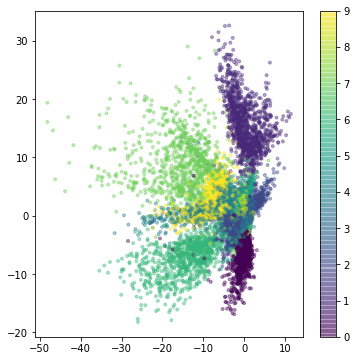

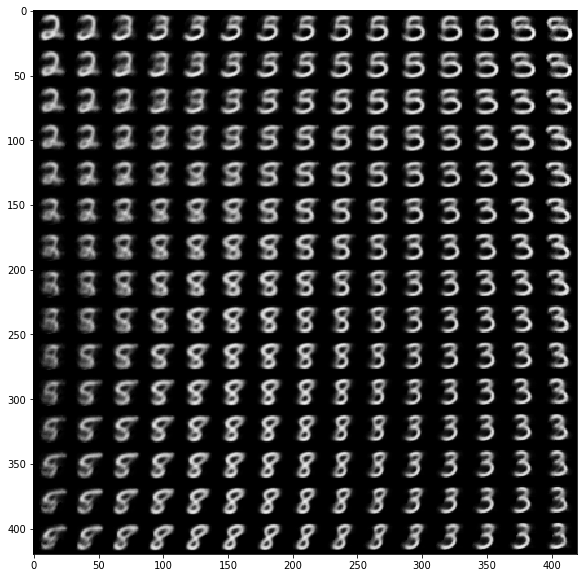

In [35]:
# display a 2D plot of the digit classes in the latent space
z_test, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')